# 09b. Demo analysis - remote part

## Overview

This notebook is intended to be executed on the cluster as a continuation of notebook

```
09a-Demo_analysis_-_local_part.ipynb
```.

## Import idact and load the cluster

We will use a wildcard import for convenience:

In [1]:
%matplotlib inline

from idact import *

In [2]:
load_environment()
cluster = show_cluster("hpc")
cluster

Cluster(pro.cyfronet.pl, 22, plggarstka, auth=AuthMethod.PUBLIC_KEY, key='/net/people/plggarstka/.ssh/id_rsa_cm', install_key=False, disable_sshd=False)

In [3]:
node = cluster.get_access_node()
node

Node(pro.cyfronet.pl:22, None)

In [4]:
node.connect()

## Pull the Dask deployment

Let's get the deployments we pushed from the local notebook:

In [5]:
deployments = cluster.pull_deployments()
deployments

2018-12-02 05:31:49 INFO: Pulling deployments.
2018-12-02 05:31:51 INFO: Installing key in '.ssh/authorized_keys.idact' for access to compute nodes.
2018-12-02 05:31:51 INFO: Creating the ssh directory.
2018-12-02 05:32:03 INFO: Desired local tunnel port 33300 is taken. Binding to random port instead.
2018-12-02 05:32:09 INFO: Desired local tunnel port 55762 is taken. Binding to random port instead.
2018-12-02 05:32:47 INFO: Pulled allocation deployment: Nodes([Node(p0109:59529, 2018-12-02 05:26:06.298927+00:00),Node(p0110:60911, 2018-12-02 05:26:06.298927+00:00),Node(p0111:58340, 2018-12-02 05:26:06.298927+00:00),Node(p0112:39446, 2018-12-02 05:26:06.298927+00:00),Node(p0113:36112, 2018-12-02 05:26:06.298927+00:00),Node(p0114:52334, 2018-12-02 05:26:06.298927+00:00)], SlurmAllocation(job_id=14399245))
2018-12-02 05:32:47 INFO: Pulled Dask deployment: DaskDeployment(scheduler=tcp://localhost:53769/tcp://172.20.64.109:46289, workers=6)


SynchronizedDeployments(nodes=1, jupyter_deployments=0, dask_deployments=1)

There is the nodes deployment:

In [6]:
nodes = deployments.nodes[-1]
nodes

Nodes([Node(p0109:59529, 2018-12-02 05:26:06.298927+00:00),Node(p0110:60911, 2018-12-02 05:26:06.298927+00:00),Node(p0111:58340, 2018-12-02 05:26:06.298927+00:00),Node(p0112:39446, 2018-12-02 05:26:06.298927+00:00),Node(p0113:36112, 2018-12-02 05:26:06.298927+00:00),Node(p0114:52334, 2018-12-02 05:26:06.298927+00:00)], SlurmAllocation(job_id=14399245))

And Dask deployment:

In [7]:
dask_deployment = deployments.dask_deployments[-1]
dask_deployment

DaskDeployment(scheduler=tcp://localhost:53769/tcp://172.20.64.109:46289, workers=6)

## Load the CSV data into a Dask DataFrame

Get a Dask client:

In [8]:
client = dask_deployment.get_client()
client

Client Scheduler: tcp://localhost:53769 Dashboard: http://localhost:33300/status,Cluster Workers: 6 Cores: 144 Memory: 773.09 GB


First, we will specify the path to the `taxi` dir we created:

In [9]:
import os
scratch = os.environ['SCRATCH']
data_root = os.path.realpath(os.path.join(scratch, 'taxi'))
data_root

'/net/scratch/people/plggarstka/taxi'

In [10]:
csvs = os.path.join(data_root, '*.csv')
csvs

'/net/scratch/people/plggarstka/taxi/*.csv'

Make sure the data is there:

In [11]:
import glob
globbed = glob.glob(csvs)
globbed[:3], len(globbed)

(['/net/scratch/people/plggarstka/taxi/yellow_tripdata_2011-08.csv',
  '/net/scratch/people/plggarstka/taxi/yellow_tripdata_2012-06.csv',
  '/net/scratch/people/plggarstka/taxi/yellow_tripdata_2010-07.csv'],
 60)

Let's see what a sample file looks like:

In [12]:
with open(globbed[0]) as f:
    head = ''.join([next(f) for i in range(5)])
print(head)

vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount

VTS,2011-08-03 21:31:00,2011-08-03 21:36:00,1,0.87,-73.991191999999998,40.754370000000002,1,,-73.978027999999995,40.751404999999998,CSH,4.9000000000000004,0.5,0.5,0,0,5.9000000000000004
VTS,2011-08-03 21:11:00,2011-08-03 21:35:00,2,5.0099999999999998,-73.994882000000004,40.728074999999997,1,,-73.978035000000006,40.773437999999999,CSH,15.699999999999999,0.5,0.5,0,0,16.699999999999999
CMT,2011-08-03 14:20:41,2011-08-03 14:28:44,1,1.3,-74.000567000000004,40.762041000000004,1,N,-73.983307999999994,40.762193000000003,CSH,6.5,0,0.5,0,0,7



We will load the files to a Dask dataframe. If you want to learn more about working with Dask, check out the links at the bottom of this notebook.

In [13]:
%%time
import dask.dataframe as dd
df = dd.read_csv(csvs,
                 parse_dates=['pickup_datetime', 'dropoff_datetime'],
                 dtype={
                     'vendor_id': str,
                     'store_and_fwd_flag': str,
                     'payment_type': str
                 },
                 error_bad_lines=False,
                 header=0,
                 names=['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'])

CPU times: user 3.55 s, sys: 226 ms, total: 3.78 s
Wall time: 5.64 s


In [14]:
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,object,datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,object,float64,float64,object,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Only a small fragment of each file was loaded. We can verify this by checking the memory usage on each node:

In [15]:
[node.resources.memory_usage for node in nodes]

[GiB(0.5723762512207031),
 GiB(0.21698379516601562),
 GiB(0.21976089477539062),
 GiB(0.21509933471679688),
 GiB(0.22831344604492188),
 GiB(0.22183990478515625)]

For the files to be loaded completely, we need to `persist` the dataframe to RAM:

In [16]:
%%time
client.persist(df)

CPU times: user 1.81 s, sys: 67.9 ms, total: 1.87 s
Wall time: 1.83 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,object,datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,object,float64,float64,object,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


This operation is executed in the background.

Observe the Dask Dashboard to see the work Dask is performing.
You can see that, as tasks are being performed, `Bytes stored` count is steadily increasing.

This is also reflected in the node memory usage:

In [ ]:
[node.resources.memory_usage for node in nodes]

And CPU usage:

In [ ]:
[node.resources.cpu_usage for node in nodes]

You can also check the resource usage from the local notebook, especially when executing a blocking computation on this notebook.

When all tasks on the dashboard are completed, we can see all the data is now in memory, spread across the workers, which are now more or less idle.

In [17]:
[node.resources.memory_usage for node in nodes]

[GiB(22.1178035736084),
 GiB(21.651426315307617),
 GiB(22.675148010253906),
 GiB(22.673763275146484),
 GiB(21.661420822143555),
 GiB(22.674121856689453)]

In [18]:
[node.resources.cpu_usage for node in nodes]

[16.0, 6.0, 6.0, 6.0, 5.0, 5.0]

## Categorize the data

We will use Pandas categoricals for better performance later. We will categorize the string columns, which have relatively few values:

In [19]:
%%time
df.head()

CPU times: user 228 ms, sys: 69.7 ms, total: 297 ms
Wall time: 9.87 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2010-01-26 07:41:00,2010-01-26 07:45:00,1,0.75,-73.956778,40.767750,1,NaN,-73.965957,40.765232,CAS,4.5,0.0,0.5,0.00,0.0,5.00
1,DDS,2010-01-30 23:31:00,2010-01-30 23:46:12,1,5.90,-73.996118,40.763932,1,NaN,-73.981512,40.741193,CAS,15.3,0.5,0.5,0.00,0.0,16.30
2,DDS,2010-01-18 20:22:20,2010-01-18 20:38:12,1,4.00,-73.979673,40.783790,1,NaN,-73.917852,40.878560,CAS,11.7,0.5,0.5,0.00,0.0,12.70
3,VTS,2010-01-09 01:18:00,2010-01-09 01:35:00,2,4.70,-73.977922,40.763997,1,NaN,-73.923908,40.759725,CAS,13.3,0.5,0.5,0.00,0.0,14.30
4,CMT,2010-01-18 19:10:14,2010-01-18 19:17:07,1,0.60,-73.990924,40.734682,1,0,-73.995511,40.739088,Cre,5.3,0.0,0.5,0.87,0.0,6.67


In [20]:
%%time
df = df.categorize(columns=['vendor_id', 'store_and_fwd_flag', 'payment_type'])

CPU times: user 15.2 s, sys: 2.87 s, total: 18.1 s
Wall time: 6min 17s


The columns are being categorized in the background. Wait until all tasks are completed and proceeed.

In [21]:
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,category[known],datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,category[known],float64,float64,category[known],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can see that the columns we selected are now categorized.

There is still some work to perform, which will happen anyway before saving to file, so let's `persist` right now:

In [22]:
%%time
client.persist(df)

CPU times: user 2.58 s, sys: 101 ms, total: 2.68 s
Wall time: 2.56 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,category[known],datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,category[known],float64,float64,category[known],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Wait until the tasks on the Dashboard are completed.

Let's look at the memory usage after categorization:

In [24]:
[node.resources.memory_usage for node in nodes]

[GiB(39.68906497955322),
 GiB(40.088866233825684),
 GiB(40.088377952575684),
 GiB(40.08748531341553),
 GiB(40.099310874938965),
 GiB(40.08858776092529)]

We're using more memory for now. We can also see the values did not change. Internally however, they are stored as numerical values:

In [25]:
%%time
df.head()

CPU times: user 181 ms, sys: 60.4 ms, total: 241 ms
Wall time: 7.83 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2010-01-26 07:41:00,2010-01-26 07:45:00,1,0.75,-73.956778,40.767750,1,NaN,-73.965957,40.765232,CAS,4.5,0.0,0.5,0.00,0.0,5.00
1,DDS,2010-01-30 23:31:00,2010-01-30 23:46:12,1,5.90,-73.996118,40.763932,1,NaN,-73.981512,40.741193,CAS,15.3,0.5,0.5,0.00,0.0,16.30
2,DDS,2010-01-18 20:22:20,2010-01-18 20:38:12,1,4.00,-73.979673,40.783790,1,NaN,-73.917852,40.878560,CAS,11.7,0.5,0.5,0.00,0.0,12.70
3,VTS,2010-01-09 01:18:00,2010-01-09 01:35:00,2,4.70,-73.977922,40.763997,1,NaN,-73.923908,40.759725,CAS,13.3,0.5,0.5,0.00,0.0,14.30
4,CMT,2010-01-18 19:10:14,2010-01-18 19:17:07,1,0.60,-73.990924,40.734682,1,0,-73.995511,40.739088,Cre,5.3,0.0,0.5,0.87,0.0,6.67


## Save the DataFrame to Apache Parquet

Create the directory for the Apache Parquet output:

In [26]:
from subprocess import run
parquet_path = os.path.join(data_root, 'taxi.parquet')
run(['mkdir', '-p', parquet_path])

CompletedProcess(args=['mkdir', '-p', '/net/scratch/people/plggarstka/taxi/taxi.parquet'], returncode=0)

Then, remove any files that might already be there:

In [27]:
parquet_to_glob = os.path.join(parquet_path, "*.parquet")
globbed_parquet = glob.glob(parquet_to_glob)
for f in globbed_parquet:
    os.remove(f)

Now, save the dataframe to Parquet:

In [28]:
%%time
df.to_parquet(parquet_path)

CPU times: user 22.8 s, sys: 1.81 s, total: 24.6 s
Wall time: 1min 15s


Let's look at the files we created:

In [29]:
globbed_parquet = glob.glob(parquet_to_glob)
globbed_parquet[:3], len(globbed_parquet)

(['/net/scratch/people/plggarstka/taxi/taxi.parquet/part.75.parquet',
  '/net/scratch/people/plggarstka/taxi/taxi.parquet/part.2256.parquet',
  '/net/scratch/people/plggarstka/taxi/taxi.parquet/part.2126.parquet'],
 2410)

We have one file for each partition.

## Restart the client and read from Parquet

Now, we will wipe the data stored in memory and try to load it from Parquet:

In [58]:
del df
client.restart()

Client Scheduler: tcp://localhost:53769 Dashboard: http://localhost:33300/status,Cluster Workers: 6 Cores: 144 Memory: 773.09 GB


We need to specify the categories manually:

In [59]:
%%time
df = dd.read_parquet(parquet_path, categories=['vendor_id', 'store_and_fwd_flag', 'payment_type'])

CPU times: user 1.35 s, sys: 267 ms, total: 1.62 s
Wall time: 1.49 s


In [60]:
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,category[unknown],datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,category[unknown],float64,float64,category[unknown],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


For the file to be loaded, we need to call `persist`, like before:

In [61]:
%%time
client.persist(df)

CPU times: user 904 ms, sys: 11.1 ms, total: 915 ms
Wall time: 907 ms


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,category[unknown],datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,category[unknown],float64,float64,category[unknown],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Look at the Dashboard. Loading should now take a fraction of time it initially took to load the CSV files.

We can also see that less memory is used than before:

In [62]:
[node.resources.memory_usage for node in nodes]

[GiB(19.235827445983887),
 GiB(17.56221294403076),
 GiB(17.560919761657715),
 GiB(17.56030559539795),
 GiB(17.572508811950684),
 GiB(17.561450004577637)]

We can `categorize` again, which will make the categorical indices known:

In [63]:
%%time
df = df.categorize()

CPU times: user 4.88 s, sys: 973 ms, total: 5.85 s
Wall time: 25.8 s


In [64]:
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=2410,,,,,,,,,,,,,,,,,,
,category[known],datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,category[known],float64,float64,category[known],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Let's take a look at the data again:

In [65]:
%%time
df.head()

CPU times: user 22.3 ms, sys: 5.41 ms, total: 27.7 ms
Wall time: 261 ms


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2010-01-26 07:41:00,2010-01-26 07:45:00,1,0.75,-73.956778,40.767750,1,NaN,-73.965957,40.765232,CAS,4.5,0.0,0.5,0.00,0.0,5.00
1,DDS,2010-01-30 23:31:00,2010-01-30 23:46:12,1,5.90,-73.996118,40.763932,1,NaN,-73.981512,40.741193,CAS,15.3,0.5,0.5,0.00,0.0,16.30
2,DDS,2010-01-18 20:22:20,2010-01-18 20:38:12,1,4.00,-73.979673,40.783790,1,NaN,-73.917852,40.878560,CAS,11.7,0.5,0.5,0.00,0.0,12.70
3,VTS,2010-01-09 01:18:00,2010-01-09 01:35:00,2,4.70,-73.977922,40.763997,1,NaN,-73.923908,40.759725,CAS,13.3,0.5,0.5,0.00,0.0,14.30
4,CMT,2010-01-18 19:10:14,2010-01-18 19:17:07,1,0.60,-73.990924,40.734682,1,0,-73.995511,40.739088,Cre,5.3,0.0,0.5,0.87,0.0,6.67


## Simple analysis

We could be asking a lot of interesting questions about the taxi dataset, but let's keep this simple for now.
Suppose we're interested in tipping habits of people taking taxis.
Let's find out:

 - What the mean tip percentage is by year, month, and hour of the day.
 - What the highest tip amount in the years 2010-2014 was.
 - What the highest tip percentage in the years 2010-2014 was.

In [66]:
paid = df[df['fare_amount'] > 0]

with_tip_percentage = paid.assign(
    tip_percentage=paid['tip_amount'] / paid['fare_amount'])

mean_by_year = with_tip_percentage.groupby(
    with_tip_percentage['pickup_datetime'].dt.year)['tip_percentage'].mean()
mean_by_month = with_tip_percentage.groupby(
    with_tip_percentage['pickup_datetime'].dt.month)['tip_percentage'].mean()
mean_by_hour = with_tip_percentage.groupby(
    with_tip_percentage['pickup_datetime'].dt.hour)['tip_percentage'].mean()

highest_amount = with_tip_percentage['tip_amount'].max()
highest_percentage = with_tip_percentage['tip_percentage'].max()

highest_amount_values = with_tip_percentage[with_tip_percentage['tip_amount'] == highest_amount]
highest_percentage_values = with_tip_percentage[with_tip_percentage['tip_percentage'] == highest_percentage]

We will persist each result first, and then view them one by one:

In [67]:
mean_by_year = client.persist(mean_by_year)
mean_by_month = client.persist(mean_by_month)
mean_by_hour = client.persist(mean_by_hour)

highest_amount = client.persist(highest_amount)
highest_percentage = client.persist(highest_percentage)

highest_amount_values = client.persist(highest_amount_values)
highest_percentage_values = client.persist(highest_percentage_values)

Let's see how many fares there were in total:

In [68]:
paid.shape[0].compute()

862697843

862.7 million trips over 5 years, that's about 470 thousand yellow taxi trips each day.

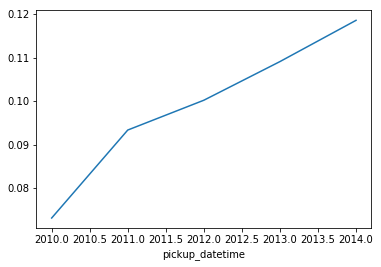

In [69]:
mean_by_year.compute().plot()

The average tip over the years has increased by over 4 percentage points.

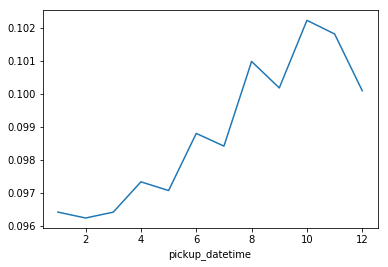

In [70]:
mean_by_month.compute().plot()

The average tip seems to increase as the year progresses, only to sharply drop after around the New Year.

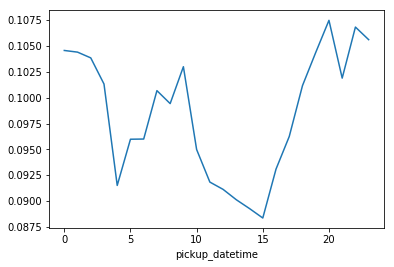

In [71]:
mean_by_hour.compute().plot()

The average tip is relatively high in the late morning hours, then sharply drops around lunch.
After 3PM, it steadily increases to reach the peak in the evening, and then drops again in the early morning.

In [72]:
highest_amount.compute()

938.02

That's a tip of $938. How many were that generous?

In [73]:
highest_amount_values.shape[0].compute()

1

Let's take a look at that fare:

In [74]:
highest_amount_values_final = highest_amount_values.head(n=1, npartitions=-1)
highest_amount_values_final

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
202709,CMT,2010-02-13 18:14:13,2010-02-13 18:21:45,2,1.0,-73.844296,40.721362,1,0,-73.856941,40.719803,CAS,5.7,0.0,0.5,938.02,0.0,944.22,164.564912


There were two passengers, and the tip was 1646%. Let's find out where they went:

In [75]:
from IPython.core.display import display, HTML

def open_maps(pdf, i):
    p_lo = pdf['pickup_longitude'].iloc[i]
    p_la = pdf['pickup_latitude'].iloc[i]
    d_lo = pdf['dropoff_longitude'].iloc[i]
    d_la = pdf['dropoff_latitude'].iloc[i]
    display(HTML('<a href="https://www.google.com/maps/dir/{},{}/{},{}">link</a>'.format(
        p_la, p_lo, d_la, d_lo)))

In [76]:
open_maps(highest_amount_values_final, 0)

And what was the highest percentage?

In [77]:
highest_percentage.compute()

12000.0

That's a tip of 120000%. How many were there?

In [78]:
highest_percentage_values.shape[0].compute()

1

In [79]:
highest_percentage_values_final = highest_percentage_values.head(n=1, npartitions=-1)
highest_percentage_values_final

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
131375,CMT,2013-08-25 00:12:01,2013-08-25 00:12:50,1,0.0,-73.991516,40.807855,5,N,-73.991556,40.807794,CRD,0.01,0.0,0.0,120.0,0.0,120.01,12000.0


There was one passenger. They paid a cent, tipped $120 and left the cab after 50 minutes. Interesting.

In [80]:
open_maps(highest_percentage_values_final, 0)

## Learn more about Dask

Here are a few helpful links:

 - [Dask Tutorial on GitHub](https://github.com/dask/dask-tutorial).
 - [Dask DataFrame Performance Tips](http://docs.dask.org/en/latest/dataframe-performance.html)
 - [Managing Memory](http://distributed.dask.org/en/latest/memory.html)
 - [Dask Distributed Documentation](http://distributed.dask.org/en/latest/quickstart.html).
 - [Dask Documentation](https://docs.dask.org/en/latest/).

## Continue with the local notebook

Perform the rest of instructions in the local notebook.